In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import xarray as xr
import numpy as np

In [2]:
#import dask to parallelise
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)

In [3]:
#load observational SST
hadsst = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_sst.nc", chunks = {'time':12}).sst
hadsst = hadsst.sortby(hadsst.latitude, ascending=True)
#rename coords
#hadsst = hadsst.rename({"lon": "longitude", "lat": "latitude"})
hadsst =hadsst.sel(time = slice("1950-01-01", "2022-12-31"))
hadsst = hadsst.compute()

In [4]:
hadsst1 = xr.where(hadsst == -1000, np.nan, hadsst)

In [5]:
def roll_lon(df):
    df.coords['longitude'] = (df.coords['longitude'] + 360) % 360# - 180
    df = df.sortby(df.longitude)
    return df

In [6]:
hadsst1 = roll_lon(hadsst1)

In [7]:
def ssta(DS):
    clim = DS.sel(time = slice("1990-01-01", "2005-12-31")).groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def NINO34(DS):
    return ssta(DS).sel(latitude=slice(-5, 5),longitude=slice(360-170, 360-120)).mean(['latitude', 'longitude'])

In [30]:
nino34 = NINO34(hadsst1)

In [33]:
test =  pd.DataFrame({'n34': nino34}, index=nino34.time)

In [38]:
test

,n34
1950-01-16 12:00:00,-1.206228
1950-02-15 00:00:00,-1.643181
1950-03-16 12:00:00,-1.184886
1950-04-16 00:00:00,-1.069930
1950-05-16 12:00:00,-1.461957
...,...
2022-08-16 12:00:00,-1.050287
2022-09-16 12:00:00,-1.133001
2022-10-16 12:00:00,-1.138670
2022-11-16 12:00:00,-0.893479


In [26]:
nino34 = nino34.to_dataset(name = "nino34")

In [42]:
nino34_df = nino34.to_pandas()

In [43]:
nino34_df = nino34_df.resample("MS").mean()

In [44]:
nino34_df

time
1950-01-01   -1.206228
1950-02-01   -1.643181
1950-03-01   -1.184886
1950-04-01   -1.069930
1950-05-01   -1.461957
                ...   
2022-08-01   -1.050287
2022-09-01   -1.133001
2022-10-01   -1.138670
2022-11-01   -0.893479
2022-12-01   -0.966501
Freq: MS, Length: 876, dtype: float32

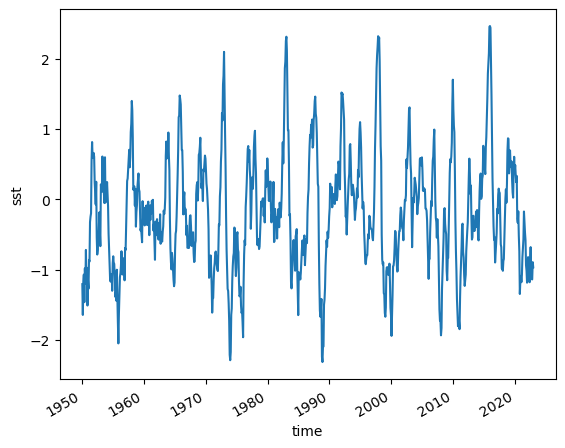

In [11]:
fig, ax = plt.subplots()
ax = nino34.plot(ax=ax)


In [48]:
from sklearn.metrics import mean_squared_error

Coefficients: [-3.78995683e-02  1.23063955e+00 -2.42977875e-01  2.50810808e-02
 -1.69468336e-02 -1.28881320e-01  7.67265533e-02 -8.27176655e-02
  2.98404037e-02 -1.81873582e-02  4.66539730e-04 -6.32862588e-03
  1.10357002e-01 -1.05993449e-01  1.03366382e-01 -1.24309225e-01
  4.91290857e-03  4.61047846e-02 -9.83215352e-03 -3.32744337e-02
  3.87644481e-02 -1.55188517e-02 -2.52204785e-02  1.58200053e-02
 -1.63351483e-02 -3.60412850e-02 -3.77414690e-02  1.84802564e-01
 -1.47862926e-01  6.47630349e-02  1.11075173e-02 -1.28595322e-01
  1.30688196e-01  5.62366173e-03 -3.71847891e-02  1.22650725e-02
 -4.99767215e-02 -5.63501330e-02  2.13704108e-01 -1.47713993e-01
  2.24035275e-02 -2.75835935e-02  3.02822659e-02 -3.38487753e-02
  2.41137453e-02  2.54487922e-02  2.19207135e-02 -7.98516796e-02
  2.83078366e-02  7.68557682e-02 -1.40321174e-01  1.15190619e-01
 -1.64993153e-01  1.47668243e-01  6.68924663e-03  7.92204312e-03
 -3.61536759e-02  4.76068310e-04 -5.80202333e-03  3.74182704e-03
  5.5330650

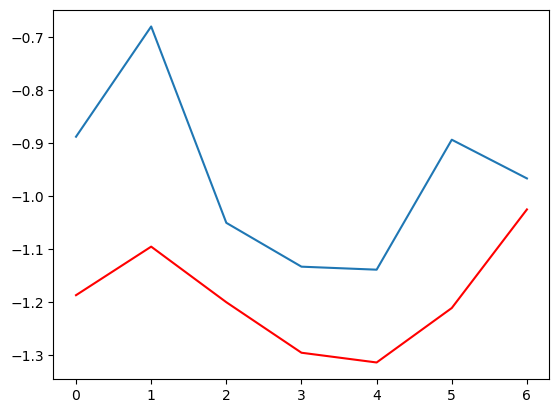

In [52]:
X = nino34_df.values
train, test = X[1:len(X)-7], X[len(X)-7:]
# train autoregression
model = AutoReg(train, lags=240)
model_fit = model.fit()
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test[i]))
rmse = np.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')


In [12]:
model = AutoReg(nino34_df, lags=12)  # example: lags=5

In [15]:
model_fit = model.predict(start=0, end=900)

TypeError: predict() missing 1 required positional argument: 'params'

In [159]:
synthetic_series = model_fit.predict(start=0, end=900)

In [160]:
model_fit.forecast()

array([-0.924186])

In [161]:
len(nino34)

876

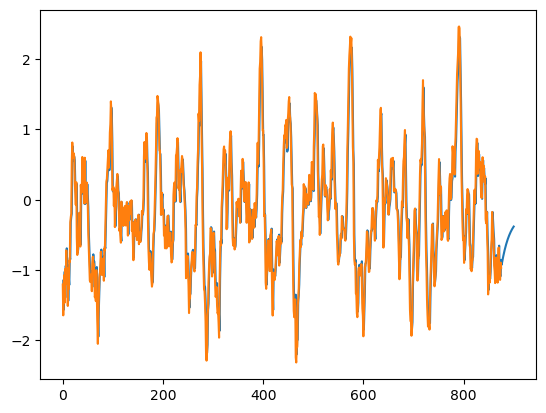

In [162]:
plt.plot(synthetic_series)
plt.plot(nino34.values)

In [184]:
start = nino34_df.index[-24]
forecast_index = pd.date_range(start, freq=nino34_df.index.freq, periods=36)
cols = ["-".join(str(val) for val in (idx.year, idx.month)) for idx in forecast_index]
forecasts = pd.DataFrame(index=forecast_index, columns=cols)

In [189]:
forecast_index[1+12]

Timestamp('2022-02-01 12:00:00', freq='MS')

In [192]:
model_fit.predict(start = 876, end = 900)

array([-0.924186  , -0.88417924, -0.84635522, -0.81059486, -0.77678557,
       -0.74482089, -0.71460019, -0.68602831, -0.6590153 , -0.6334761 ,
       -0.60933031, -0.5865019 , -0.56491899, -0.54451364, -0.52522159,
       -0.5069821 , -0.48973775, -0.47343425, -0.45802025, -0.44344723,
       -0.42966931, -0.4166431 , -0.4043276 , -0.39268402, -0.38167571])

In [ ]:
for i in range(1, 24):
    fcast = model_fit.predict(
        start=forecast_index[i], end=forecast_index[i + 12], dynamic=True
    )
    forecasts.loc[fcast.index, cols[i]] = fcast
_, ax = plt.subplots(figsize=(16, 10))
nino34_df.iloc[-24:].plot(ax=ax, color="black", linestyle="--")
ax = forecasts.plot(ax=ax)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [82]:
from pandas.plotting import lag_plot

In [86]:
series = nino34_df

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

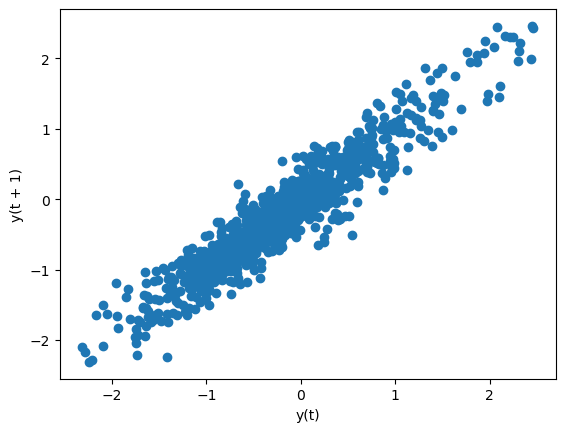

In [85]:
lag_plot(nino34)

In [96]:
values = series
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.94578
t+1  0.94578  1.00000


In [99]:
pd.plotting.plot_acf(nino34_df)

AttributeError: module 'pandas.plotting' has no attribute 'plot_acf'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

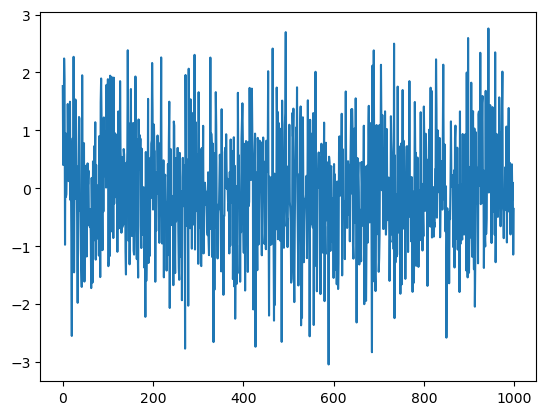

In [101]:
plt.plot(random_series)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1000
Model:                     AutoReg(1)   Log Likelihood               -1403.241
Method:               Conditional MLE   S.D. of innovations              0.986
Date:                Thu, 18 Jan 2024   AIC                           2812.482
Time:                        15:58:02   BIC                           2827.202
Sample:                             1   HQIC                          2818.077
                                 1000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0479      0.031     -1.531      0.126      -0.109       0.013
y.L1           0.4907      0.028     17.826      0.000       0.437       0.545
                                    Roots           

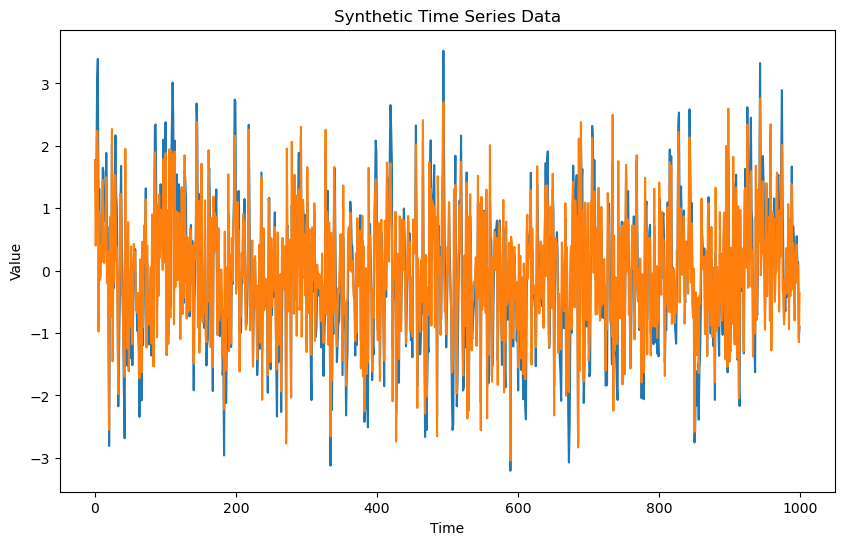

In [102]:
# Number of samples
n = 1000

# Generate a random series
np.random.seed(0)
random_series = np.random.normal(0, 1, n)

# AR(1) model with a coefficient of 0.5
phi = 0.5

# Generate synthetic time series data
synthetic_data = [random_series[0]]
for t in range(1, n):
    synthetic_data.append(phi * synthetic_data[t-1] + random_series[t])

# Convert to pandas Series for convenience
synthetic_series = pd.Series(synthetic_data)

# Fit the AR model to the synthetic data
model = AutoReg(synthetic_series, lags=1)
model_fit = model.fit()

# Summary of the model
print(model_fit.summary())

# Plot the synthetic time series data
plt.figure(figsize=(10, 6))
plt.plot(synthetic_series)
plt.plot(random_series)
plt.title('Synthetic Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()
